WSC - initial data prep
* read in pickle
* split into chapters
* run several functions to chunk the text
* all in dataframes this time compared to lists in tex_prep_v02

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import textacy
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


Bad key "text.kerning_factor" on line 4 in
/Users/Steven/opt/anaconda3/envs/textacy/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
import pickle
import os

In [11]:
raw_texts_dir = '../../../../Documents/murakami/pkl_raw_books/'
raw_texts_list = os.listdir(raw_texts_dir)

In [12]:
raw_texts_list

['HarukiMurakami_TheElephantVanishes.pkl',
 'HarukiMurakami_NorwegianWood.pkl',
 'HarukiMurakami_TheWindUpBirdChronicle.pkl',
 'HarukiMurakami_AWildSheepChase.pkl',
 'HarukiMurakami_KafkaOnTheShore.pkl',
 'HarukiMurakami_ColorlessTsukuruTazaki.pkl',
 'HarukiMurakami_NorwegianWoodB.pkl',
 'HarukiMurakami_DanceDanceDance.pkl']

In [22]:
# split the pkl file name on the . and _ and keep the book name
titles = [y.split('_')[1] for y in [x.split('.')[0] for x in raw_texts_list]]
# insert spaces between the capitalized words in the tiles
titles = [re.sub( r"([A-Z])", r" \1", z).strip() for z in titles]
titles

['The Elephant Vanishes',
 'Norwegian Wood',
 'The Wind Up Bird Chronicle',
 'A Wild Sheep Chase',
 'Kafka On The Shore',
 'Colorless Tsukuru Tazaki',
 'Norwegian Wood B',
 'Dance Dance Dance']

In [23]:
book_dict = {'Title':titles,'Pickle':raw_texts_list}

In [25]:
books = pd.DataFrame(book_dict)
books

,Title,Pickle
0,The Elephant Vanishes,HarukiMurakami_TheElephantVanishes.pkl
1,Norwegian Wood,HarukiMurakami_NorwegianWood.pkl
2,The Wind Up Bird Chronicle,HarukiMurakami_TheWindUpBirdChronicle.pkl
3,A Wild Sheep Chase,HarukiMurakami_AWildSheepChase.pkl
4,Kafka On The Shore,HarukiMurakami_KafkaOnTheShore.pkl
5,Colorless Tsukuru Tazaki,HarukiMurakami_ColorlessTsukuruTazaki.pkl
6,Norwegian Wood B,HarukiMurakami_NorwegianWoodB.pkl
7,Dance Dance Dance,HarukiMurakami_DanceDanceDance.pkl


In [3]:
book_dict = {'The Elephant Vanishes': 'ev_birnbaum_rubin_v01', 
             'Norwegian Wood 1': 'nw_birnbaum_v01', 
             'Norwegian Wood 2': 'nw_rubin_v01',
             'Wild Sheep Chase': 'wsc_birnbaum_v01', 
             'Wind Up Bird Chronicle': 'wubc_all_rubin_v01', 
             'Sputnik Sweetheart': 'ss_gabriel_v01',
             'Kafka on the Shore': 'kots_gabriel_v01'}

In [4]:
books = pd.DataFrame.from_dict(book_dict, orient='index').reset_index()
books.columns = ['Title', 'Pickle']
books

,Title,Pickle
0,The Elephant Vanishes,ev_birnbaum_rubin_v01
1,Norwegian Wood 1,nw_birnbaum_v01
2,Norwegian Wood 2,nw_rubin_v01
3,Wild Sheep Chase,wsc_birnbaum_v01
4,Wind Up Bird Chronicle,wubc_all_rubin_v01
5,Sputnik Sweetheart,ss_gabriel_v01
6,Kafka on the Shore,kots_gabriel_v01


In [26]:
def load_pickle(filename):
    in_path = raw_texts_dir + filename 
    with open (in_path, 'rb') as fp:
        return pickle.load(fp)

In [5]:
def load_pickle(filename):
    in_path = '../../../../Documents/murakami/pkl/' + filename + '.pkl'
    with open (in_path, 'rb') as fp:
        return pickle.load(fp)

In [27]:
books['full_text'] = books['Pickle'].apply(load_pickle)

In [28]:
books

,Title,Pickle,full_text
0,The Elephant Vanishes,HarukiMurakami_TheElephantVanishes.pkl,I’M IN THE kitchen cooking spaghetti when the ...
1,Norwegian Wood,HarukiMurakami_NorwegianWood.pkl,"[\n , Haruki Murakami Norwegian Wood This book..."
2,The Wind Up Bird Chronicle,HarukiMurakami_TheWindUpBirdChronicle.pkl,"[\n , \n , Contents \n Cover \n About the Auth..."
3,A Wild Sheep Chase,HarukiMurakami_AWildSheepChase.pkl,"[\n , \n \n \n , Contents \n Cover \n About th..."
4,Kafka On The Shore,HarukiMurakami_KafkaOnTheShore.pkl,[Kafka on the Shore \n Haruki Murakami \n \n \...
5,Colorless Tsukuru Tazaki,HarukiMurakami_ColorlessTsukuruTazaki.pkl,"[\n , \n \n \n , Contents \n Cover \n About th..."
6,Norwegian Wood B,HarukiMurakami_NorwegianWoodB.pkl,C H II P T E R 6 (rontinutd) The scene at dinn...
7,Dance Dance Dance,HarukiMurakami_DanceDanceDance.pkl,"[\n , \n \n \n , Contents \n Cover \n About th..."


### Initial cleaning and preparation of 'A Wild Sheep Chase' Text

In [95]:
wsc = books['full_text'].iloc[3]

In [96]:
# wsc is read from an epub and is a list of texts
len(wsc)

63

In [97]:
wsc[6][:30]

'\n PART ONE \n \n A PRELUDE \n '

In [98]:
wsc[6].startswith('\n PART')

True

In [99]:
# loop through the sections from 6 to 57 which contain the main body of the work
# the book is split into parts and we seperate the part headers from the main text
part_headers = []
texts = []
for i, section in enumerate(wsc[6:58]):
    if section.startswith('\n PART'):
        part_headers.append(section)
    else:
        texts.append(section)

In [100]:
# regex pattern to extract chapter number, title and main text from a complete chapter
pattern = re.compile(r'\n ([\d\w]+) \n \n ([^\n]+) \n ([\w\W]+)')

ch_nos = []
ch_titles = []
ch_texts = []
ireg_ch = []

for t in range(0,len(texts)):
#     print(t)
    out = re.findall(pattern, texts[t])
    if len(out) > 0:
        ch_nos.append(out[0][0])
        ch_titles.append(out[0][1])
        ch_texts.append(out[0][2])
    else:
        ireg_ch.append(texts[t])

In [101]:
len(ireg_ch)

0

In [102]:
chapters = pd.DataFrame({'number': ch_nos, 'title': ch_titles, 'text': ch_texts})
chapters.head()

,number,title,text
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...
1,2,Sixteen Steps,I WAITED FOR the compressed-air hiss of the e...
2,3,The Slip,"ONCE SHE WAS gone, I downed another cola, the..."
3,4,The Whale’s Penis and the Woman with Three Occ...,TO SLEEP WITH a woman: it can seem of the utm...
4,5,Unblocked Ears,“ SEE WHAT I mean?” she said. \n She’d becom...


In [103]:
# function to find indices of full stops in a text
def fs_indexer(x):
    return [i for i, char in enumerate(x) if char == "."]

In [104]:
chapters['fstop_indices'] = chapters['text'].apply(lambda x: fs_indexer(x))

In [105]:
chapters.head()

,number,title,text,fstop_indices
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65..."
1,2,Sixteen Steps,I WAITED FOR the compressed-air hiss of the e...,"[101, 215, 252, 271, 338, 413, 468, 625, 706, ..."
2,3,The Slip,"ONCE SHE WAS gone, I downed another cola, the...","[76, 157, 246, 302, 371, 507, 543, 627, 699, 8..."
3,4,The Whale’s Penis and the Woman with Three Occ...,TO SLEEP WITH a woman: it can seem of the utm...,"[125, 229, 420, 514, 598, 686, 788, 874, 937, ..."
4,5,Unblocked Ears,“ SEE WHAT I mean?” she said. \n She’d becom...,"[30, 84, 129, 178, 243, 314, 382, 481, 541, 56..."


In [106]:
# function to find indices of full stops in a text
def split_indexer(text, n=1000):
    fstop_indices = fs_indexer(text)
    split_indices = []
    try:
        for j in range(n, len(text), n):
            i = 0
    # keep going through the indices while less than the 1000 step
            while fstop_indices[i] < j:
                i += 1
    # append list with the index of the full stop before the 1000 step
            split_indices.append(fstop_indices[i-1])
    except:
        split_indices = np.NaN
    return split_indices

In [107]:
# # function to find indices of full stops in a text
# def split_indexer(text, n=1000):
#     fstop_indices = fs_indexer(text)
#     split_indices = []
#     for j in range(n, len(text), n):
#         i = 0
# # keep going through the indices while less than the 1000 step
#         while fstop_indices[i] < j:
#             i += 1
# # append list with the index of the full stop before the 1000 step
#         split_indices.append(fstop_indices[i-1])
#     return split_indices

In [108]:
chapters['split_indices'] = chapters['text'].apply(lambda x: split_indexer(x))

In [109]:
chapters.head()

,number,title,text,fstop_indices,split_indices
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961..."
1,2,Sixteen Steps,I WAITED FOR the compressed-air hiss of the e...,"[101, 215, 252, 271, 338, 413, 468, 625, 706, ...","[965, 1976, 2982, 3963, 4966, 5989, 6994, 7905..."
2,3,The Slip,"ONCE SHE WAS gone, I downed another cola, the...","[76, 157, 246, 302, 371, 507, 543, 627, 699, 8...","[952, 1904, 2975, 3996, 4929]"
3,4,The Whale’s Penis and the Woman with Three Occ...,TO SLEEP WITH a woman: it can seem of the utm...,"[125, 229, 420, 514, 598, 686, 788, 874, 937, ...","[937, 1988, 2967, 3981, 4994, 5949, 6936, 7995..."
4,5,Unblocked Ears,“ SEE WHAT I mean?” she said. \n She’d becom...,"[30, 84, 129, 178, 243, 314, 382, 481, 541, 56...",[965]


In [110]:
# function to chunk a text
def text_chunker(text):
    split_indices = split_indexer(text)
    chunks = []
    for i, idx in enumerate(split_indices):
# if first split then start at index 0 and keep up to the full stop index (including the full stop)
        if i == 0:
            chunks.append(text[0:idx+1])
# else start from the end of the previous chunk after the full stop until the next
        else:
            chunks.append(text[split_indices[i-1]+2:idx+1])
    return chunks

In [111]:
chapters['chunks'] = chapters['text'].apply(lambda x: text_chunker(x))

In [112]:
chapters.head()

,number,title,text,fstop_indices,split_indices,chunks
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",[IT WAS A short one-paragraph item in the mor...
1,2,Sixteen Steps,I WAITED FOR the compressed-air hiss of the e...,"[101, 215, 252, 271, 338, 413, 468, 625, 706, ...","[965, 1976, 2982, 3963, 4966, 5989, 6994, 7905...",[I WAITED FOR the compressed-air hiss of the ...
2,3,The Slip,"ONCE SHE WAS gone, I downed another cola, the...","[76, 157, 246, 302, 371, 507, 543, 627, 699, 8...","[952, 1904, 2975, 3996, 4929]","[ONCE SHE WAS gone, I downed another cola, th..."
3,4,The Whale’s Penis and the Woman with Three Occ...,TO SLEEP WITH a woman: it can seem of the utm...,"[125, 229, 420, 514, 598, 686, 788, 874, 937, ...","[937, 1988, 2967, 3981, 4994, 5949, 6936, 7995...",[TO SLEEP WITH a woman: it can seem of the ut...
4,5,Unblocked Ears,“ SEE WHAT I mean?” she said. \n She’d becom...,"[30, 84, 129, 178, 243, 314, 382, 481, 541, 56...",[965],[“ SEE WHAT I mean?” she said. \n She’d beco...


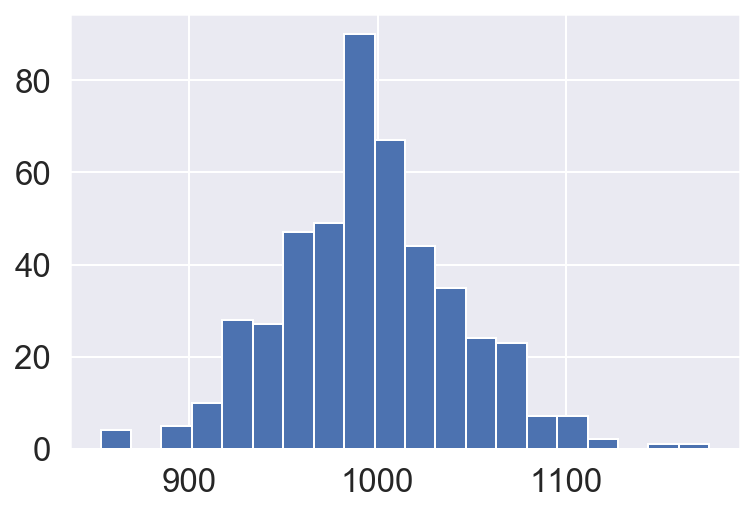

In [113]:
lengths = []
for chapter in chapters['chunks']:
    for chunk in chapter:
        lengths.append(len(chunk))
plt.hist(lengths, bins=20);

In [114]:
len(lengths)

471

In [115]:
chapters['translator'] = 'Alfred Birnbaum'

In [49]:
chapters['book_title'] = 'A Wild Sheep Chase'

In [50]:
chapters.head()

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",[IT WAS A short one-paragraph item in the mor...,Alfred Birnbaum,A Wild Sheep Chase
1,2,Sixteen Steps,I WAITED FOR the compressed-air hiss of the e...,"[101, 215, 252, 271, 338, 413, 468, 625, 706, ...","[965, 1976, 2982, 3963, 4966, 5989, 6994, 7905...",[I WAITED FOR the compressed-air hiss of the ...,Alfred Birnbaum,A Wild Sheep Chase
2,3,The Slip,"ONCE SHE WAS gone, I downed another cola, the...","[76, 157, 246, 302, 371, 507, 543, 627, 699, 8...","[952, 1904, 2975, 3996, 4929]","[ONCE SHE WAS gone, I downed another cola, th...",Alfred Birnbaum,A Wild Sheep Chase
3,4,The Whale’s Penis and the Woman with Three Occ...,TO SLEEP WITH a woman: it can seem of the utm...,"[125, 229, 420, 514, 598, 686, 788, 874, 937, ...","[937, 1988, 2967, 3981, 4994, 5949, 6936, 7995...",[TO SLEEP WITH a woman: it can seem of the ut...,Alfred Birnbaum,A Wild Sheep Chase
4,5,Unblocked Ears,“ SEE WHAT I mean?” she said. \n She’d becom...,"[30, 84, 129, 178, 243, 314, 382, 481, 541, 56...",[965],[“ SEE WHAT I mean?” she said. \n She’d beco...,Alfred Birnbaum,A Wild Sheep Chase


In [51]:
out_path = '../../../../Documents/murakami/pkl2/'
out_name = 'wsc_birnbaum_v01'
out_full_path = out_path + out_name + '.pkl'

In [52]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(chapters, fp)


# read back pickle
with open (out_full_path, 'rb') as fp:
    read_wsc = pickle.load(fp)

In [53]:
read_wsc

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",[IT WAS A short one-paragraph item in the mor...,Alfred Birnbaum,A Wild Sheep Chase
1,2,Sixteen Steps,I WAITED FOR the compressed-air hiss of the e...,"[101, 215, 252, 271, 338, 413, 468, 625, 706, ...","[965, 1976, 2982, 3963, 4966, 5989, 6994, 7905...",[I WAITED FOR the compressed-air hiss of the ...,Alfred Birnbaum,A Wild Sheep Chase
2,3,The Slip,"ONCE SHE WAS gone, I downed another cola, the...","[76, 157, 246, 302, 371, 507, 543, 627, 699, 8...","[952, 1904, 2975, 3996, 4929]","[ONCE SHE WAS gone, I downed another cola, th...",Alfred Birnbaum,A Wild Sheep Chase
3,4,The Whale’s Penis and the Woman with Three Occ...,TO SLEEP WITH a woman: it can seem of the utm...,"[125, 229, 420, 514, 598, 686, 788, 874, 937, ...","[937, 1988, 2967, 3981, 4994, 5949, 6936, 7995...",[TO SLEEP WITH a woman: it can seem of the ut...,Alfred Birnbaum,A Wild Sheep Chase
4,5,Unblocked Ears,“ SEE WHAT I mean?” she said. \n She’d becom...,"[30, 84, 129, 178, 243, 314, 382, 481, 541, 56...",[965],[“ SEE WHAT I mean?” she said. \n She’d beco...,Alfred Birnbaum,A Wild Sheep Chase
5,6,The Further Adventures of Unblocked Ears,"THE MANIFESTATION OF her full splendor, thoug...","[67, 229, 311, 369, 415, 450, 494, 560, 631, 7...","[978, 1992, 2974, 3965, 4976]","[THE MANIFESTATION OF her full splendor, thou...",Alfred Birnbaum,A Wild Sheep Chase
6,7,Before the Strange Man,THERE ARE VARIOUS reasons why an individual m...,"[151, 208, 257, 333, 441, 526, 546, 568, 684, ...","[942, 1963, 2878, 3990, 4981, 5977, 6944, 7951...",[THERE ARE VARIOUS reasons why an individual ...,Alfred Birnbaum,A Wild Sheep Chase
7,8,Now the Strange Man,IT WAS ELEVEN o’clock in the morning when the...,"[55, 143, 199, 220, 238, 241, 321, 404, 443, 4...","[924, 1958, 2949, 3961, 4921, 5970, 6975, 7948...",[IT WAS ELEVEN o’clock in the morning when th...,Alfred Birnbaum,A Wild Sheep Chase
8,9,“ The Boss ”,"“ THAT’S THE SIZE of it,” said my partner. \n...","[42, 118, 185, 260, 340, 402, 557, 614, 668, 7...","[942, 1946, 2923, 3917, 4996, 5895, 6959]","[“ THAT’S THE SIZE of it,” said my partner. \...",Alfred Birnbaum,A Wild Sheep Chase
9,10,Counting Sheep,"WE CAN, IF we so choose, wander aimlessly ove...","[78, 154, 245, 317, 509, 612, 738, 763, 828, 8...","[956, 1958, 2971, 3901, 4946]","[WE CAN, IF we so choose, wander aimlessly ov...",Alfred Birnbaum,A Wild Sheep Chase


### Initial cleaning and preparation of 'Dance Dance Dance' Text

In [54]:
ddd = books['full_text'].iloc[7]

In [58]:
len(ddd)

56

Selecting text from within list by manula check

In [59]:
ddd[7][:30]

'\n I OFTEN DREAM  about the Dol'

In [60]:
ddd[50][-30:]

'ispered.  “It’s morning.” \n \n '

In [61]:
ch_texts = ddd[7:51]

* No chapter titles available in the actual text so create them using counters
* Run similar splitting on full stops and add columnsa as before

In [80]:
ch_nos = range(1,45)
ch_titles = range(1,45)
chapters = pd.DataFrame({'number': ch_nos, 'title': ch_titles, 'text': ch_texts})
chapters['fstop_indices'] = chapters['text'].apply(lambda x: fs_indexer(x))
chapters['split_indices'] = chapters['text'].apply(lambda x: split_indexer(x))
chapters['chunks'] = chapters['text'].apply(lambda x: text_chunker(x))
chapters['translator'] = 'Alfred Birnbaum'
chapters['book_title'] = 'Dance Dance Dance'

In [81]:
chapters.head()

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
0,1,1,\n I OFTEN DREAM about the Dolphin Hotel. \n ...,"[40, 119, 182, 233, 277, 322, 360, 396, 421, 4...","[881, 1974, 2990, 3882, 4988, 5962, 6982, 7990...",[\n I OFTEN DREAM about the Dolphin Hotel. \n...,Alfred Birnbaum,Dance Dance Dance
1,2,2,\n I GOT SENT to Hokkaido on assignment. As ...,"[39, 121, 208, 314, 519, 605, 660, 736, 781, 8...","[995, 1977, 2983, 3986, 4999, 5949, 6950]",[\n I GOT SENT to Hokkaido on assignment. As...,Alfred Birnbaum,Dance Dance Dance
2,3,3,\n IT TAKES NO great effort to find work in t...,"[95, 161, 287, 368, 407, 459, 497, 558, 596, 6...","[945, 1969, 2946, 3985, 4976, 5994, 6958, 7840]",[\n IT TAKES NO great effort to find work in ...,Alfred Birnbaum,Dance Dance Dance
3,4,4,"\n I BOOKED A taxi for two days, and the phot...","[127, 187, 282, 299, 428, 505, 597, 723, 784, ...","[979, 1960, 2993, 3999, 4943, 5959, 6979, 7964...","[\n I BOOKED A taxi for two days, and the pho...",Alfred Birnbaum,Dance Dance Dance
4,5,5,\n I COULDN’T STAND around gawking at the faç...,"[56, 145, 222, 321, 407, 502, 634, 649, 747, 8...","[877, 1975, 2889, 3971, 4904, 5992, 6983, 7952...",[\n I COULDN’T STAND around gawking at the fa...,Alfred Birnbaum,Dance Dance Dance


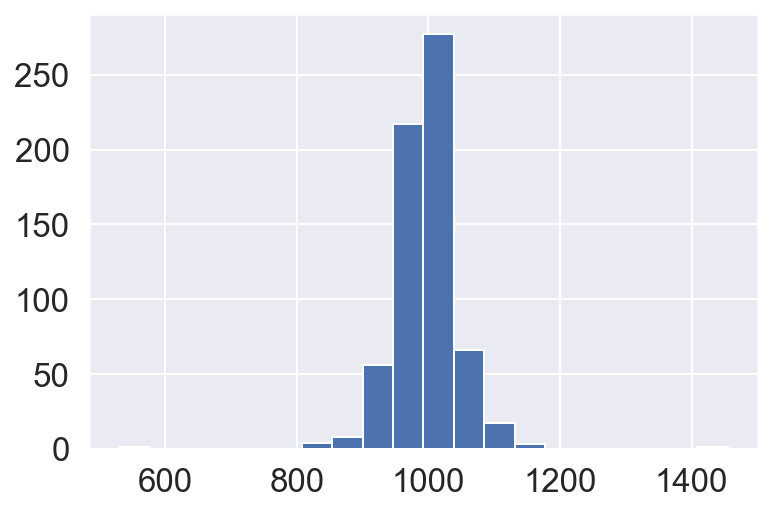

In [82]:
lengths = []
for chapter in chapters['chunks']:
    for chunk in chapter:
        lengths.append(len(chunk))
plt.hist(lengths, bins=20);

In [83]:
len(lengths)

650

In [84]:
out_path = '../../../../Documents/murakami/pkl2/'
out_name = 'ddd_birnbaum_v01'
out_full_path = out_path + out_name + '.pkl'

In [85]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(chapters, fp)


# # read back pickle
# with open (out_full_path, 'rb') as fp:
#     read_ddd = pickle.load(fp)

In [86]:
# read_ddd.head()

### Initial cleaning and preparation of 'Kafka On The Shore' Text

In [116]:
kots = books['full_text'].iloc[4]

In [117]:
len(kots)

53

In [118]:
texts = [ch for i, ch in enumerate(kots) if i not in [0,2]]

In [119]:
pattern1 = re.compile(r'\n ([\w\d\s]+) \n ([\w\W]+)')
pattern2 = re.compile(r'\n [\w]+ ([\d]+) \n [\w\W]+')

ch_nos = []
ch_titles = []
ch_texts = []

for t in range(0,len(texts)):
#     print(t)
    out1 = re.findall(pattern1, texts[t])
    out2 = re.findall(pattern2, texts[t])
#     print(len(out2))
    if len(out2) > 0:
        ch_nos.append(out2[0])
        ch_titles.append(out1[0][0])
        ch_texts.append(out1[0][1])
    else:
        ch_nos.append(None)
        ch_titles.append(out1[0][0])
        ch_texts.append(out1[0][1])

In [127]:
chapters = pd.DataFrame({'number': ch_nos, 'title': ch_titles, 'text': ch_texts})
chapters['fstop_indices'] = chapters['text'].apply(lambda x: fs_indexer(x))
chapters.dropna(inplace=True)
chapters['split_indices'] = chapters['text'].apply(lambda x: split_indexer(x))
chapters.dropna(inplace=True)
chapters['chunks'] = chapters['text'].apply(lambda x: text_chunker(x))
chapters['translator'] = 'Philip Gabriel'
chapters['book_title'] = 'Kafka On The Shore'
chapters.head(10)

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
1,1,Chapter 1,Cash isn't the only thing I take from my fathe...,"[73, 186, 247, 304, 368, 418, 490, 564, 675, 7...","[898, 1995, 2985, 3931, 4933, 5923, 6938, 7978...",[Cash isn't the only thing I take from my fath...,Philip Gabriel,Kafka On The Shore
2,2,Chapter 2,"The following document, classified Top Secret ...","[54, 56, 154, 222, 224, 252, 342, 375, 535, 57...","[878, 1901, 2996, 3947, 4936, 5847, 6928, 7936...","[The following document, classified Top Secret...",Philip Gabriel,Kafka On The Shore
3,3,Chapter 3,It's nearly dawn when I wake up. I draw the cu...,"[31, 72, 149, 230, 283, 312, 422, 553, 644, 68...","[982, 1949, 2758, 3877, 4974, 5952, 6982, 7986...",[It's nearly dawn when I wake up. I draw the c...,Philip Gabriel,Kafka On The Shore
4,4,Chapter 4,U.S. ARMY INTELLIGENCE SECTION (MIS) REPORT \n...,"[1, 3, 322, 422, 461, 576, 664, 754, 784, 786,...","[989, 1967, 2950, 3983, 4907, 5960, 6955, 7944...",[U.S. ARMY INTELLIGENCE SECTION (MIS) REPORT \...,Philip Gabriel,Kafka On The Shore
5,5,Chapter 5,I'm asleep when our bus drives across the huge...,"[77, 162, 217, 253, 329, 421, 465, 559, 582, 5...","[979, 1980, 2983, 3987, 4922, 5957, 6952, 7958...",[I'm asleep when our bus drives across the hug...,Philip Gabriel,Kafka On The Shore
6,6,Chapter 6,"Hello there,"" the old man called out. \n The l...","[36, 147, 193, 216, 243, 249, 250, 251, 271, 3...","[971, 1951, 2976, 3923, 4927, 5921, 6963, 7948...","[Hello there,"" the old man called out. \n The ...",Philip Gabriel,Kafka On The Shore
7,7,Chapter 7,At seven-fifteen I eat breakfast in the restau...,"[98, 165, 228, 298, 320, 378, 415, 511, 582, 6...","[948, 1907, 2982, 3928, 4921, 5973, 6997, 7999...",[At seven-fifteen I eat breakfast in the resta...,Philip Gabriel,Kafka On The Shore
8,8,\n Chapter 8,U.S. ARMY INTELLIGENCE SECTION (MIS) REPORT \n...,"[1, 3, 433, 537, 579, 618, 757, 869, 977, 1064...","[977, 1856, 2913, 3948, 4993, 5975, 6993, 7943...",[U.S. ARMY INTELLIGENCE SECTION (MIS) REPORT \...,Philip Gabriel,Kafka On The Shore
9,9,Chapter 9,"When I come to I'm in thick brush, lying there...","[79, 114, 247, 298, 357, 422, 493, 568, 615, 7...","[937, 1998, 2979, 3968, 4967, 5955, 6955, 7960...","[When I come to I'm in thick brush, lying ther...",Philip Gabriel,Kafka On The Shore
10,10,Chapter 10,"Is it all right, then, if Nakata calls you Kaw...","[178, 302, 356, 444, 486, 532, 597, 632, 666, ...","[954, 1913, 2986, 3937, 4946, 5993, 6978, 7964...","[Is it all right, then, if Nakata calls you Ka...",Philip Gabriel,Kafka On The Shore


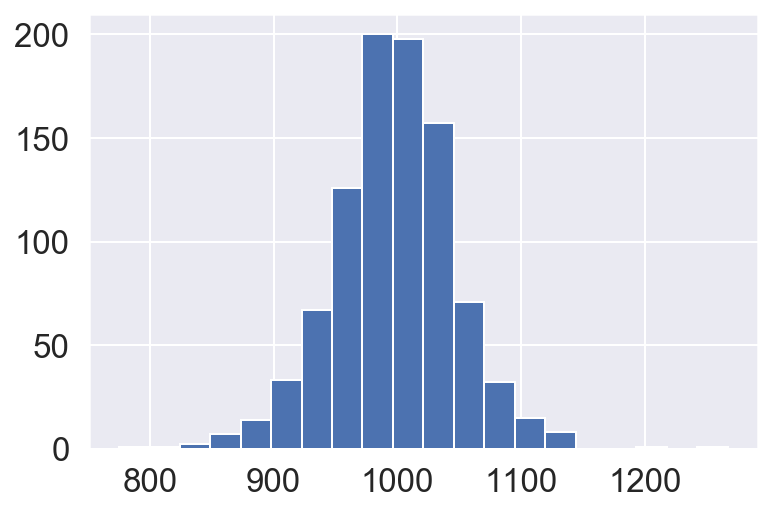

In [128]:
lengths = []
for chapter in chapters['chunks']:
    for chunk in chapter:
        lengths.append(len(chunk))
plt.hist(lengths, bins=20);

In [129]:
len(lengths)

934

In [130]:
out_path = '../../../../Documents/murakami/pkl2/'
out_name = 'kots_gabriel_v01'
out_full_path = out_path + out_name + '.pkl'

In [133]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(chapters, fp)


# # read back pickle
# with open (out_full_path, 'rb') as fp:
#     read_kots = pickle.load(fp)

In [134]:
# read_kots